In [ ]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

In [ ]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T
from datetime import datetime

builder = (
SparkSession.builder.appName("DeltaRideHailing")
.config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

trip_schema = T.StructType([
T.StructField("trip_id", T.IntegerType()),
T.StructField("rider_id", T.StringType()),
T.StructField("driver_id", T.StringType()),
T.StructField("city", T.StringType()),
T.StructField("distance_km", T.DoubleType()),
T.StructField("fare", T.DoubleType()),
T.StructField("tip", T.DoubleType()),
T.StructField("ts", T.TimestampType())
])
driver_schema = T.StructType([
T.StructField("driver_id", T.StringType()),
T.StructField("driver_name",T.StringType()),
T.StructField("rating", T.DoubleType()),
T.StructField("vehicle", T.StringType())
])
trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0, datetime(2025,8,8,8,5,0)),
    (1002,"R002","D011","Hyderabad", 6.2, 150.0, 10.0, datetime(2025,8,8,8,15,0)),
    (1003,"R003","D012","Pune", 3.5, 90.0, 0.0, datetime(2025,8,8,8,20,0)),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0, datetime(2025,8,8,8,45,0)),
    (1005,"R004","D013","Chennai", 10.0, 260.0, 15.0, datetime(2025,8,8,9,5,0)),
    (1006,"R005","D012","Pune", 2.2, 70.0, 0.0, datetime(2025,8,8,9,10,0))
]
drivers_rows = [
("D010","Anil", 4.8,"WagonR"),
("D011","Sana", 4.6,"i20"),
("D012","Rakesh", 4.4,"Swift"),
("D013","Meera", 4.9,"Ciaz")
]
trips_df = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"
trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)
print("Seeded:")
print(" Trips ->", TRIPS_PATH)
print(" Drivers->", DRIVERS_PATH)


Seeded:
 Trips -> /tmp/delta/ride_hailing/trips
 Drivers-> /tmp/delta/ride_hailing/drivers


#1) Managed vs Unmanaged Tables

In [ ]:
spark.sql("drop table if exists trips_managed")
spark.sql(f"create table trips_managed using delta as select * from delta.`{TRIPS_PATH}`")

DataFrame[]

In [ ]:
spark.sql("drop table if exists drivers_ext")
spark.sql(f" create table drivers_ext using delta location '{DRIVERS_PATH}'")

DataFrame[]

In [ ]:
spark.sql("DESCRIBE DETAIL trips_managed").select("location").show(truncate=False)

spark.sql("DESCRIBE DETAIL drivers_ext").select("location").show(truncate=False)


+-------------------------------------------+
|location                                   |
+-------------------------------------------+
|file:/content/spark-warehouse/trips_managed|
+-------------------------------------------+

+------------------------------------+
|location                            |
+------------------------------------+
|file:/tmp/delta/ride_hailing/drivers|
+------------------------------------+



#2) Read & Explore

In [ ]:
trips_df = spark.table("trips_managed")
trips_df.printSchema()
trips_df.show(10, truncate=False)

drivers_df = spark.table("drivers_ext")
drivers_df.printSchema()
drivers_df.show(10, truncate=False)



root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   |R003    |D012     |Pu

In [ ]:
trips_with_total = trips_df.withColumn("total_amount", F.col("fare") + F.col("tip"))
trips_with_total.orderBy(F.col("total_amount").desc()).show(5, truncate=False)


+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|505.0       |
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|340.0       |
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|275.0       |
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|160.0       |
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|90.0        |
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
only showing top 5 rows



#3) Update (Business Rule)

In [ ]:
from delta.tables import DeltaTable
trips_delta = DeltaTable.forPath(spark, TRIPS_PATH)
condition = (F.col("city") == "Bengaluru") & (F.col("distance_km") > 15)
print("Affected rows BEFORE update:")
trips_delta.toDF().filter(condition).show(truncate=False)
trips_delta.update(
    condition="city = 'Bengaluru' AND distance_km > 15",
    set={"tip": "tip + 5"}
)

print("Affected rows AFTER update:")
trips_delta.toDF().filter(condition).show(truncate=False)


#4) Delete (Data Quality)

In [ ]:
trips_delta.toDF().filter((F.col("fare") <= 0) | (F.col("distance_km") <= 0)).show(truncate=False)
trips_delta.delete("fare <= 0 OR distance_km <= 0")
remaining_count = trips_delta.toDF().count()
print(f"Remaining rows after deletion: {remaining_count}")


#5) Merge (Upsert New Batch)

In [ ]:
new_trips_data = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 35.0, "2025-08-08 08:45:00"),
    (1007, "R006", "D014", "Mumbai", 8.0, 200.0, 10.0, "2025-08-08 10:00:00")
]

new_batch_df = spark.createDataFrame(new_trips_data, schema=trip_schema)
trips_delta = DeltaTable.forPath(spark, TRIPS_PATH)

trips_delta.alias("t").merge(new_batch_df.alias("s"),"t.trip_id = s.trip_id").whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()
trips_delta.toDF().filter(F.col("trip_id").isin(1004, 1007)).show(truncate=False)


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1004   |R001    |D010     |Bengaluru|18.9       |500.0|35.0|2025-08-08 08:45:00|
|1007   |R006    |D014     |Mumbai   |8.0        |200.0|10.0|2025-08-08 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#6) Gold View (Join & KPIs)

In [ ]:
trips_with_total = spark.read.format("delta").load(TRIPS_PATH)\
    .withColumn("total_amount", F.col("fare") + F.col("tip"))

gold_df = trips_with_total.join(drivers_df, on="driver_id", how="left") \
    .select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")

gold_df.orderBy("trip_id").show(truncate=False)


+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|city     |driver_name|rating|distance_km|total_amount|ts                 |
+-------+---------+-----------+------+-----------+------------+-------------------+
|1001   |Bengaluru|Anil       |4.8   |12.4       |340.0       |2025-08-08 08:05:00|
|1002   |Hyderabad|Sana       |4.6   |6.2        |160.0       |2025-08-08 08:15:00|
|1003   |Pune     |Rakesh     |4.4   |3.5        |90.0        |2025-08-08 08:20:00|
|1004   |Bengaluru|Anil       |4.8   |18.9       |535.0       |2025-08-08 08:45:00|
|1005   |Chennai  |Meera      |4.9   |10.0       |275.0       |2025-08-08 09:05:00|
|1006   |Pune     |Rakesh     |4.4   |2.2        |70.0        |2025-08-08 09:10:00|
|1007   |Mumbai   |NULL       |NULL  |8.0        |210.0       |2025-08-08 10:00:00|
+-------+---------+-----------+------+-----------+------------+-------------------+



In [ ]:
city= gold_df.groupBy("city").agg(F.sum("total_amount").alias("total_revenue"),F.avg("rating").alias("avg_driver_rating")).orderBy("city")
city.show(truncate=False)


+---------+-------------+-----------------+
|city     |total_revenue|avg_driver_rating|
+---------+-------------+-----------------+
|Bengaluru|875.0        |4.8              |
|Chennai  |275.0        |4.9              |
|Hyderabad|160.0        |4.6              |
|Mumbai   |210.0        |NULL             |
|Pune     |160.0        |4.4              |
+---------+-------------+-----------------+



In [ ]:
driver = gold_df.groupBy("driver_name").agg( F.count("trip_id").alias("total_trips"), F.sum("total_amount").alias("total_revenue")).orderBy(F.desc("total_revenue"))
driver.show(3, truncate=False)




+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|Anil       |2          |875.0        |
|Meera      |1          |275.0        |
|NULL       |1          |210.0        |
+-----------+-----------+-------------+
only showing top 3 rows



#7) Time Travel & History

In [ ]:
trips_delta.history().show(truncate=False)

+-------+-----------------------+------+--------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|version|

In [ ]:
trips_v0 = spark.read.format("delta").option("versionAsOf", 0).load(TRIPS_PATH)
print("Version 0 row count:", trips_v0.count())
trips_v0.show(truncate=False)

trips_latest = spark.read.format("delta").load(TRIPS_PATH)
print("Latest version row count:", trips_latest.count())
trips_latest.show(truncate=False)


Version 0 row count: 6
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

Latest version row count: 7
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance

#8) Partitioned Rewrite (Performance)

In [ ]:
PARTITIONED_PATH = f"{BASE}/trips_partitioned"
trips_df.write.format("delta") .mode("overwrite").partitionBy("city") .save(PARTITIONED_PATH)
print("Partitioned trips table written to:", PARTITIONED_PATH)


Partitioned trips table written to: /tmp/delta/ride_hailing/trips_partitioned


In [ ]:
from time import time
start = time()
bengaluru_trips = spark.read.format("delta").load(PARTITIONED_PATH).filter(F.col("city") == "Bengaluru")
bengaluru_trips.show(truncate=False)
end = time()
print(f"Read time for Bengaluru trips: {end - start:.3f} seconds")


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1004   |R001    |D010     |Bengaluru|18.9       |500.0|40.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

Read time for Bengaluru trips: 1.300 seconds


#9) Incremental Load Simulation

In [ ]:
incremental_trips = [
    (1008, "R007", "D015", "Mumbai", 5.0, 120.0, 15.0, datetime(2025,8,8,11,0,0)),
    (1009, "R008", "D016", "Mumbai", 7.5, 180.0, 20.0, datetime(2025,8,8,11,30,0))
]
incremental_df = spark.createDataFrame(incremental_trips, schema=trip_schema)

trips_delta.alias("t").merge( incremental_df.alias("s"),"t.trip_id = s.trip_id").whenNotMatchedInsertAll().execute()


In [ ]:
trips_with_total = spark.read.format("delta").load(TRIPS_PATH) \
    .withColumn("total_amount", F.col("fare") + F.col("tip"))

gold_df = trips_with_total.join(drivers_df, on="driver_id", how="left") .select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")
city_new = gold_df.groupBy("city") .agg(F.sum("total_amount").alias("total_revenue"),F.avg("rating").alias("avg_driver_rating")).orderBy("city")

city_new.show(truncate=False)


+---------+-------------+-----------------+
|city     |total_revenue|avg_driver_rating|
+---------+-------------+-----------------+
|Bengaluru|880.0        |4.8              |
|Chennai  |275.0        |4.9              |
|Hyderabad|160.0        |4.6              |
|Mumbai   |545.0        |NULL             |
|Pune     |160.0        |4.4              |
+---------+-------------+-----------------+



#11) Visualization

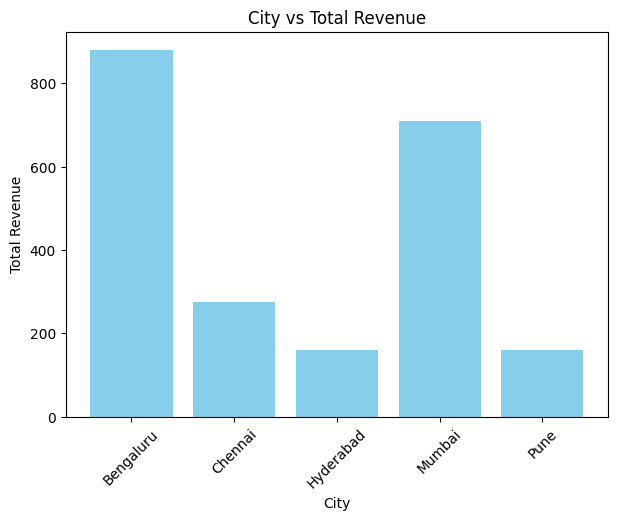

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

city_revenue_df = gold_df.groupBy("city") \
    .agg(F.sum("total_amount").alias("total_revenue")) \
    .orderBy("city") \
    .toPandas()
plt.figure(figsize=(7,5))
plt.bar(city_revenue_df['city'],city_revenue_df['total_revenue'], color='skyblue')
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.title("City vs Total Revenue")
plt.xticks(rotation=45)
plt.show()


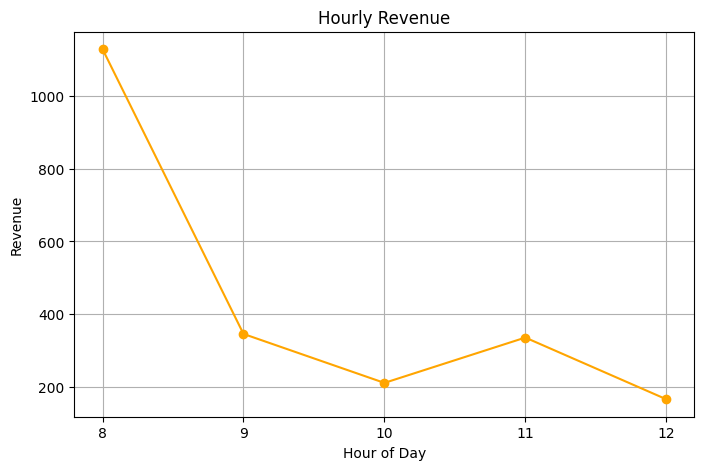

In [ ]:
hourly_df = gold_df.withColumn("hour", F.hour("ts")) \
    .groupBy("hour") \
    .agg(F.sum("total_amount").alias("hourly_revenue")) \
    .orderBy("hour") \
    .toPandas()

plt.figure(figsize=(8,5))
plt.plot(hourly_df['hour'], hourly_df['hourly_revenue'], marker='o', color='orange')
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.title("Hourly Revenue")
plt.xticks(hourly_df['hour'])
plt.grid(True)
plt.show()


#12) Managed vs Unmanaged Cleanup

In [ ]:
spark.sql("drop table if exists trips_managed")
spark.sql("drop table if exists drivers_ext")


DataFrame[]

In [ ]:
import os
managed_path = "/user/hive/warehouse/trips_managed"  # adjust if different in your environment
print( os.path.exists(managed_path))


False


In [ ]:
print( os.path.exists(DRIVERS_PATH))
print( os.listdir(DRIVERS_PATH))


True
['_delta_log', 'part-00000-17ffef67-c6fe-4d6f-b54f-aa048e62f2a3-c000.snappy.parquet', '.part-00000-17ffef67-c6fe-4d6f-b54f-aa048e62f2a3-c000.snappy.parquet.crc', '.part-00001-e2b3b5e4-f3f0-4431-9096-9e2bd8c63705-c000.snappy.parquet.crc', 'part-00000-80d374ae-ff45-41de-8cd1-e98cc695d5a4-c000.snappy.parquet', '.part-00001-298de370-3cc4-4b66-a1e1-b1c6c176dac1-c000.snappy.parquet.crc', 'part-00001-298de370-3cc4-4b66-a1e1-b1c6c176dac1-c000.snappy.parquet', 'part-00001-e2b3b5e4-f3f0-4431-9096-9e2bd8c63705-c000.snappy.parquet', '.part-00000-80d374ae-ff45-41de-8cd1-e98cc695d5a4-c000.snappy.parquet.crc']


#13) Constraint/Quality Check (Optional)

In [ ]:
bad_trips = [
    (1011, "R010", "D018", "Delhi", 10.0, 250.0, -5.0, datetime(2025,8,8,12,30,0)),
    (1012, "R011", "D019", "Delhi", 8.0, 200.0, 10.0, datetime(2025,8,8,12,45,0))
]

bad_trips_df = spark.createDataFrame(bad_trips, schema=trip_schema)
valid_trips_df = bad_trips_df.filter(F.col("tip") >= 0)
trips_delta = DeltaTable.forPath(spark, TRIPS_PATH)
trips_delta.alias("t").merge(valid_trips_df.alias("s"), "t.trip_id = s.trip_id").whenNotMatchedInsertAll().execute()
trips_delta.toDF().filter(F.col("trip_id").isin(1011,1012)).show(truncate=False)


+-------+--------+---------+-----+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city |distance_km|fare |tip |ts                 |
+-------+--------+---------+-----+-----------+-----+----+-------------------+
|1012   |R011    |D019     |Delhi|8.0        |200.0|10.0|2025-08-08 12:45:00|
+-------+--------+---------+-----+-----------+-----+----+-------------------+



#14) Convert Parquet → Delta (Optional)

In [ ]:
sample_trips_df = trips_with_total.limit(3)
PARQUET_PATH = f"{BASE}/trips_parquet"
sample_trips_df.write.mode("overwrite").parquet(PARQUET_PATH)
print("Parquet saved at:", PARQUET_PATH)
spark.sql(f"CONVERT TO DELTA parquet.`{PARQUET_PATH}`")
print("Conversion to Delta complete.")
delta_df = spark.read.format("delta").load(PARQUET_PATH)
delta_df.show(truncate=False)


Parquet saved at: /tmp/delta/ride_hailing/trips_parquet
Conversion to Delta complete.
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |500.0|40.0|2025-08-08 08:45:00|540.0       |
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|275.0       |
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|70.0        |
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+



In [ ]:
new_batch = [(2001, "R020", "D020", "Bengaluru", 12.0, 300.0, 25.0, datetime(2025,8,8,13,0,0))]
new_batch_df = spark.createDataFrame(new_batch, schema=trip_schema)
new_batch_df = new_batch_df.withColumn("total_amount", F.col("fare") + F.col("tip"))
delta_table = DeltaTable.forPath(spark, PARQUET_PATH)
delta_table.alias("t").merge(new_batch_df.alias("s"), "t.trip_id = s.trip_id") \
    .whenNotMatchedInsertAll().execute()

delta_table.toDF().show(truncate=False)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |500.0|40.0|2025-08-08 08:45:00|540.0       |
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|275.0       |
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|70.0        |
|2001   |R020    |D020     |Bengaluru|12.0       |300.0|25.0|2025-08-08 13:00:00|325.0       |
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+



In [ ]:
version_0_df = spark.read.format("delta").option("versionAsOf", 0).load(PARQUET_PATH)
version_0_df.show(truncate=False)

new_df = spark.read.format("delta").load(PARQUET_PATH)
new_df.show(truncate=False)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |500.0|40.0|2025-08-08 08:45:00|540.0       |
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|275.0       |
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|70.0        |
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       

#15) Bonus KPI Dashboard (Notebook Display)

In [ ]:
total_revenue = gold_df.agg(F.sum("total_amount").alias("total_revenue")).collect()[0]["total_revenue"]
print("Total Revenue:", total_revenue)


Total Revenue: 2395.0


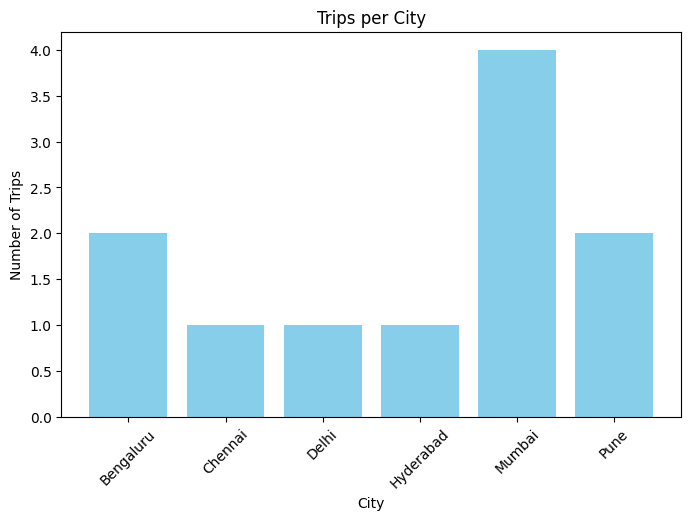

In [ ]:
city_trips_df = gold_df.groupBy("city").agg(F.count("trip_id").alias("trips")).orderBy("city").toPandas()

plt.figure(figsize=(8,5))
plt.bar(city_trips_df['city'], city_trips_df['trips'], color='skyblue')
plt.xlabel("City")
plt.ylabel("Number of Trips")
plt.title("Trips per City")
plt.xticks(rotation=45)
plt.show()


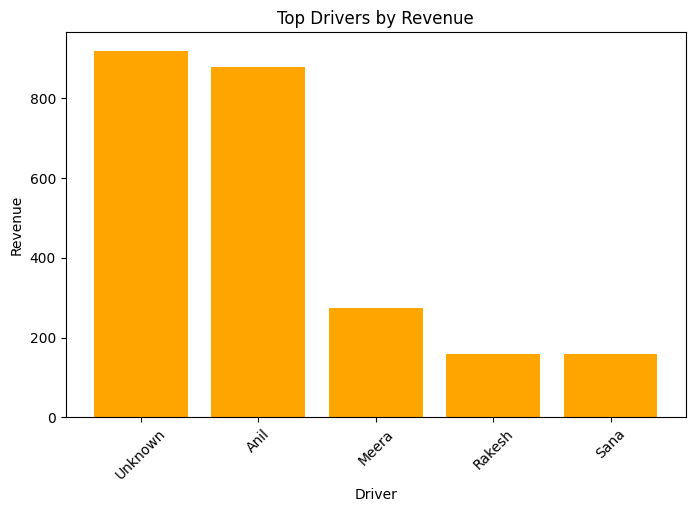

In [ ]:
driver_revenue_df = gold_df.groupBy("driver_name").agg(F.sum("total_amount").alias("revenue")).orderBy(F.desc("revenue")).toPandas()

plt.figure(figsize=(8,5))
plt.bar(driver_revenue_df['driver_name'], driver_revenue_df['revenue'], color='orange')
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.title("Top Drivers by Revenue")
plt.xticks(rotation=45)
plt.show()


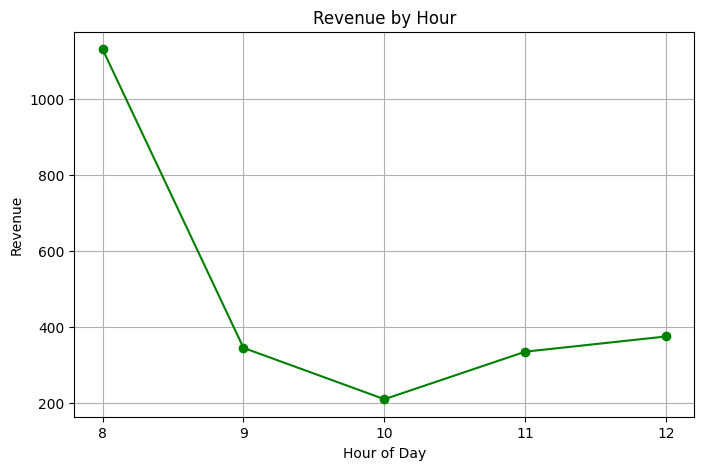

In [ ]:
hourly_df = gold_df.withColumn("hour", F.hour("ts")).groupBy("hour").agg(F.sum("total_amount").alias("hourly_revenue")).orderBy("hour").toPandas()

plt.figure(figsize=(8,5))
plt.plot(hourly_df['hour'], hourly_df['hourly_revenue'], marker='o', color='green')
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.title("Revenue by Hour")
plt.xticks(hourly_df['hour'])
plt.grid(True)
plt.show()
